# Analyzing experiment from 1/8/2016

In [1]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io
import itertools
import os
import h5py
import pyret.visualizations as pyviz
import pyret.filtertools as ft
import pyret.spiketools as st
import pyret.stimulustools as stimtools
import jetpack
from experiments.iotools import read_channel # from niru-analysis github
from experiments.photodiode import find_peaks, find_start_times
# import binary     # in igor >> recording
import pdb
import string
# from jetpack.signals import peakdet
from scipy.signal import find_peaks_cwt
from os.path import expanduser

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, xlabel, ylabel, title, imshow

# note that nonposx(y) for log plots will no longer work with this package
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## experiment directory

In [2]:
data_dir = '/Users/lmcintosh/experiments/data/16-01-08/'
stim_dir = '/Users/lmcintosh/experiments/data/16-01-08/stimulus/'
stimulus_filename = '16-01-08-stimulus.h5'

## load spikes

In [3]:
fs = sorted(os.listdir(data_dir))
fs = [f for f in fs if f.endswith(".txt")]

cells = []
for f in fs:
    text_file = open(data_dir + f, "r")
    spikes = text_file.read().split('\n')
    cells.append([float(spike) for spike in spikes if (not (not spike)) and float(spike) > 0])
    
    text_file.close()

In [4]:
len(cells)

14

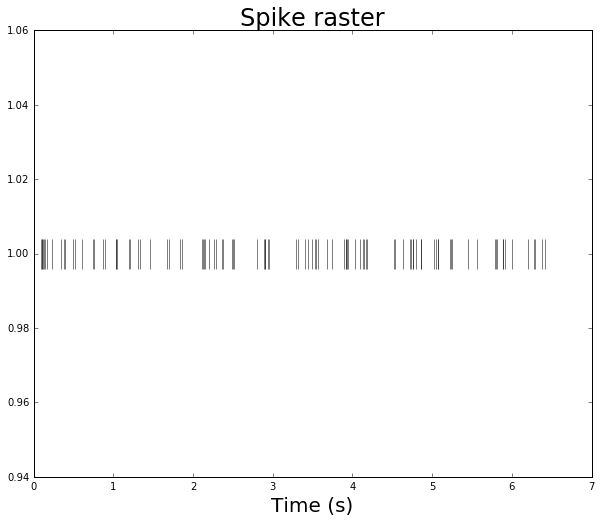

In [5]:
fig = pyviz.raster(cells[0][:100], np.ones((len(cells[0][:100]),)), marker_string='|', color='k', markersize=30)

## load stimulus

In [6]:
f = h5py.File(stim_dir + stimulus_filename)
list(f)

[u'expt1',
 u'expt10',
 u'expt11',
 u'expt12',
 u'expt13',
 u'expt14',
 u'expt15',
 u'expt16',
 u'expt17',
 u'expt18',
 u'expt19',
 u'expt2',
 u'expt20',
 u'expt21',
 u'expt22',
 u'expt23',
 u'expt24',
 u'expt3',
 u'expt4',
 u'expt5',
 u'expt6',
 u'expt7',
 u'expt8',
 u'expt9']

In [7]:
list(f['expt1'])

[u'stim', u'timestamps']

In [8]:
(f['expt1/stim'].shape, f['expt1/timestamps'].shape)

((19997, 50, 50), (19997,))

## find peaks in photodiode to align each experiment

#### load photodiode

In [9]:
raw_data = h5py.File(data_dir + '16-1-8.h5')
pd = read_channel(raw_data, channel=0)

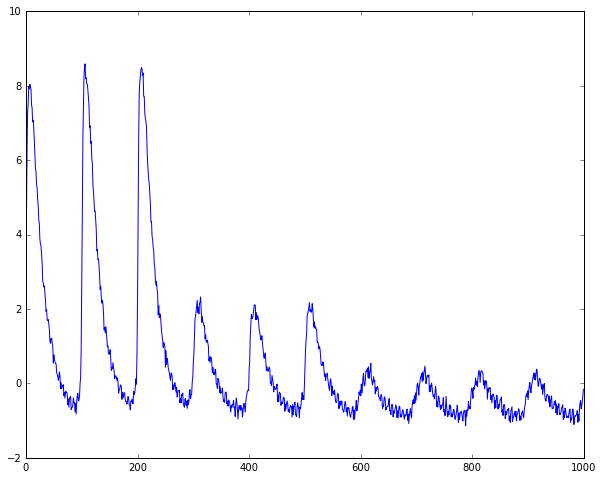

In [10]:
plt.plot(pd[:1000])

#### find peaks

In [11]:
# delta is the threshold for accepting optima; i.e. optima must be delta greater than neighboring values
# delta = 1.0 # this finds all photodiode peaks
# delta = 8.58
delta = 8.58
maxtab = find_peaks(pd, delta)

➛ Finding peaks (can take a minute)... 
Done! ✔


In [12]:
# expectation of maxtab shape is 24 experiments * 3 flips per frame = 72
maxtab.shape

(72, 2)

In [13]:
maxtab[0,:]

array([ 7.        ,  8.03932241])

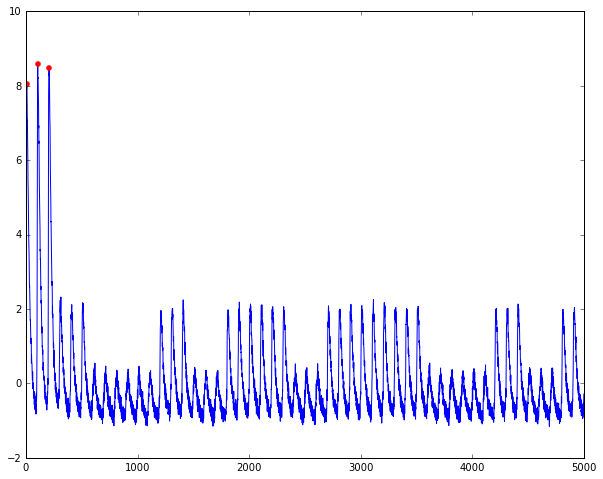

In [14]:
plt.plot(pd[:5000])
# plt.plot(maxtab[:50, 0], maxtab[:50, 1], 'r.', markersize=10)
plt.plot(maxtab[:3, 0], maxtab[:3, 1], 'r.', markersize=10)

In [15]:
# from cycling through threshold-crossings, the 24 expt start times are
maxtab_start_indices = [2, 5, 16, 18, 20, 23, 26, 28, 31, 34, 36, 38, 41, 44, 47, 50, 53, 56, 58, 60, 63, 66, 68, 71]

In [16]:
len(maxtab_start_indices)

24

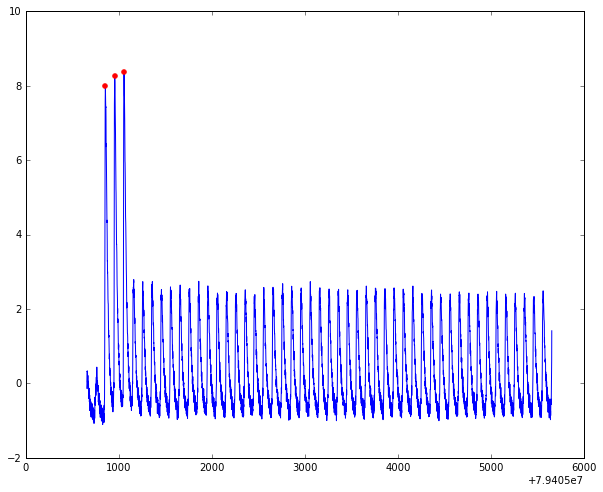

In [17]:
view = int(maxtab[69,0]) - 200
view_end = view + 5000

maxtab_trunc = maxtab[np.bitwise_and(maxtab[:,0] >= view, maxtab[:,0] < view_end), :]

plt.plot(np.linspace(view, view_end, len(pd[view:view_end])), pd[view:view_end], 'b')
plt.plot(maxtab_trunc[:,0], maxtab_trunc[:, 1], 'r.', markersize=10)
# plt.plot(maxtab[:,0], maxtab[:,1], 'k.')

#### Go from maxtab_start_indices to start times in seconds

In [18]:
from jetpack.timepiece import hrtime

In [19]:
offset = 0.02 # shifting stimulus 20 ms ahead since we're taking the 3rd photodiode
sampling_rate = 10e3
refresh_rate = 100
start_times = []

for expt_id, idx in enumerate(maxtab_start_indices):
    pd_idx = maxtab[idx, 0]
  
    # the start times are the times of the last flip in each group (in
    # seconds), plus an offset equal to a single monitor refresh
    # start_times = grouped[:, -1] / sampling_rate + 1 / refresh_rate
    time = pd_idx / sampling_rate + 1 / refresh_rate - offset
    start_times.append(time)
    
print('Found {} different stimulus sequences at the following times:'.format(len(start_times)))
for ix, t in enumerate(start_times):
    print('Stimulus #{:2} started at t = {}'.format(ix+1, t))#hrtime(t)))

Found 24 different stimulus sequences at the following times:
Stimulus # 1 started at t = 0.0007
Stimulus # 2 started at t = 600.3713
Stimulus # 3 started at t = 678.1355
Stimulus # 4 started at t = 1289.274
Stimulus # 5 started at t = 1350.3267
Stimulus # 6 started at t = 1950.7275
Stimulus # 7 started at t = 2013.8318
Stimulus # 8 started at t = 2614.4628
Stimulus # 9 started at t = 2674.5349
Stimulus #10 started at t = 3274.8754
Stimulus #11 started at t = 3343.8036
Stimulus #12 started at t = 3955.4423
Stimulus #13 started at t = 4015.9948
Stimulus #14 started at t = 4616.4357
Stimulus #15 started at t = 4676.728
Stimulus #16 started at t = 5277.3391
Stimulus #17 started at t = 5337.411
Stimulus #18 started at t = 5937.7717
Stimulus #19 started at t = 6006.9302
Stimulus #20 started at t = 6618.4687
Stimulus #21 started at t = 6679.2313
Stimulus #22 started at t = 7279.6622
Stimulus #23 started at t = 7339.9545
Stimulus #24 started at t = 7940.5855


In [20]:
f['expt1/timestamps'][-1]

600.32637000000068

# Align spikes with each experiment

In [21]:
expt_spikes = []
for expt_id, start in enumerate(start_times):
    expt_spikes.append([])
    expt_name = 'expt%d' %(expt_id+1)
    stop = f[expt_name + '/timestamps'][-1] # last timestamp, in seconds
    for c in cells:
        expt_spikes[-1].append([sp-start for sp in c if sp >= start and sp <= start+stop])

In [22]:
def spikes_to_array(spikes):
    '''
    Converts a list of spike times to an array with labels for easy
    pyret.visualizations.raster() use.
    
    INPUT:
        spikes    list of list of spike times
    '''
    collapsed_spikes = []
    collapsed_labels = []
    nlists = len(spikes)
    for idl, l in enumerate(spikes):
        labels = idl * np.ones((len(l),))
        collapsed_spikes.extend(l)
        collapsed_labels.extend(labels)
        
    return np.array(collapsed_spikes), np.array(collapsed_labels)
    

In [23]:
all_spikes, all_labels = spikes_to_array(expt_spikes[1])

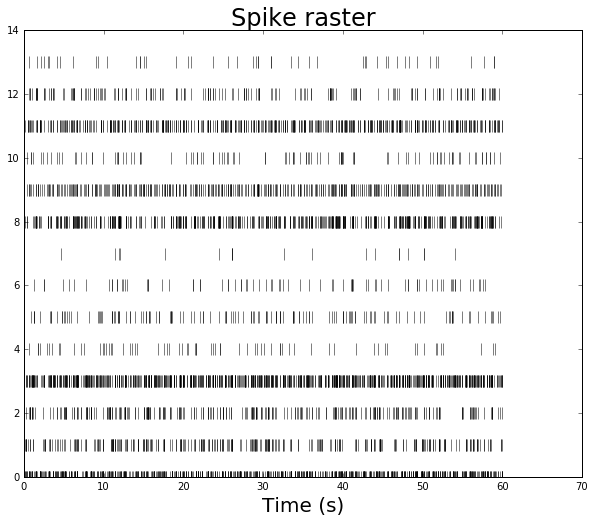

In [24]:
fig = pyviz.raster(all_spikes, all_labels, marker_string='|', color='k', markersize=12)

# look at trial-to-trial variability of a single cell to repeated natural movies

In [25]:
cell_idx = 0
first_trial = 7
num_diff_trials = 8
total_trials = 24
repeats = []
for t in range(first_trial, total_trials, num_diff_trials):
    repeats.append(expt_spikes[t][cell_idx])

all_spikes, all_labels = spikes_to_array(repeats)

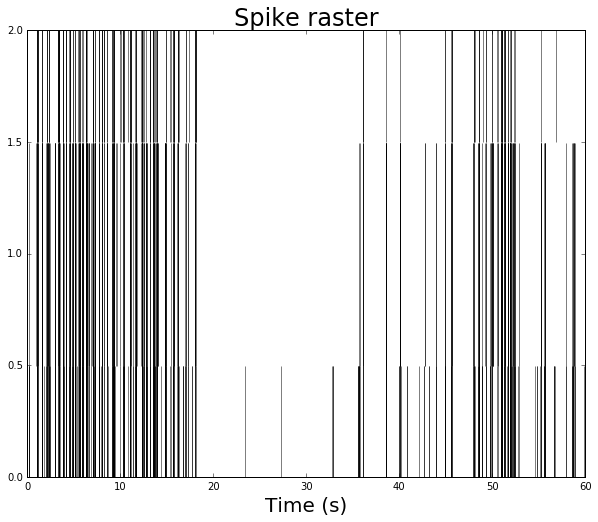

In [26]:
fig = pyviz.raster(all_spikes, all_labels, marker_string='|', color='k', markersize=223)

# look at trial-to-trial variability of a single cell to repeated white noise

In [27]:
cell_idx = 0
first_trial = 1
num_diff_trials = 8
total_trials = 24
repeats = []
for t in range(first_trial, total_trials, num_diff_trials):
    repeats.append(expt_spikes[t][cell_idx])

all_spikes, all_labels = spikes_to_array(repeats)

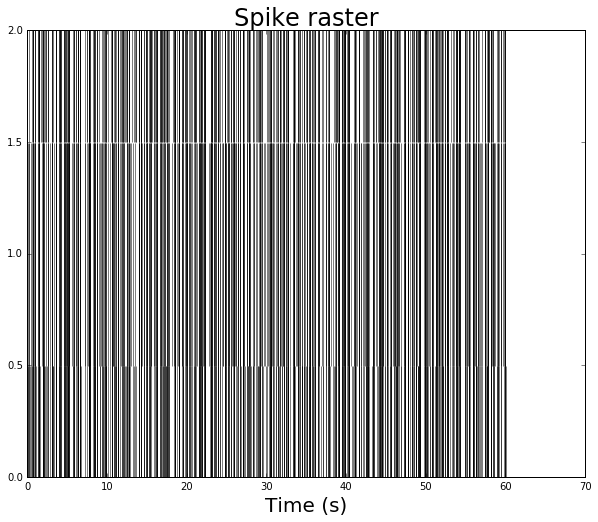

In [28]:
fig = pyviz.raster(all_spikes, all_labels, marker_string='|', color='k', markersize=223)

In [29]:
len(cells)

14

In [30]:
import brewer2mpl

In [31]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

(0, 60)

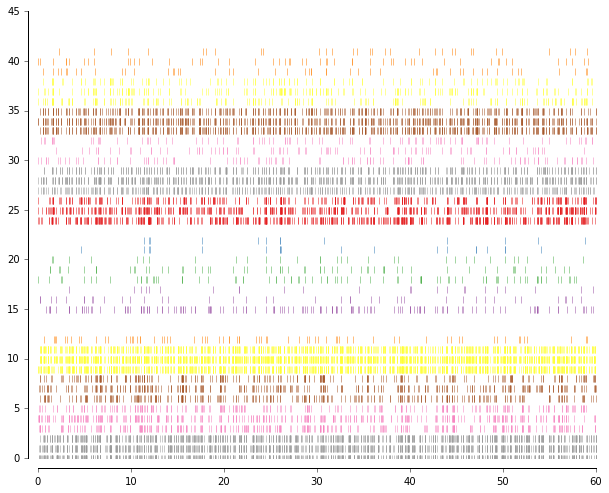

In [32]:
ax = plt.gca()
bmap = brewer2mpl.get_map('Set1', 'Qualitative', 9, reverse=True)
colors = bmap.mpl_colors

# structured stimuli
first_trial = 1
num_diff_trials = 8
total_trials = 24
num_repeats = 3
for c in range(len(cells)):
    repeats = []
    for t in range(first_trial, total_trials, num_diff_trials):
        repeats.append(expt_spikes[t][c])

    all_spikes, all_labels = spikes_to_array(repeats)
    all_labels += num_repeats * c
    
    # plot raster for this particular cell
    which_color = c % 9
    ax.plot(all_spikes, all_labels, '|', markersize=7, color=colors[which_color])

plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.xlim([0, 60])

# Check out the STAs for the 14 cells

In [33]:
from scipy.stats import zscore

In [34]:
# cell_idx = 0
# first_trial = 7
# num_diff_trials = 8
# total_trials = 24

stas = []

# whitenoise_expts = range(0,24,8)
whitenoise_expts = [0, 1, 8, 9, 16, 17]
# whitenoise_expts = [0, 1, 16, 17]
# whitenoise_expts = [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 22, 23]
for c in range(len(cells)):
    partial_sta = np.zeros((40, 50, 50))
    for expt_id in whitenoise_expts:
        expt_name = 'expt%d' %(expt_id+1)
        time = f[expt_name + '/timestamps']
        stimulus = zscore(f[expt_name + '/stim'])
        stimulus_upsample, time_upsample = stimtools.upsample_stim(stimulus, 3, time)
        sta, tax = ft.getsta(time_upsample, stimulus_upsample, expt_spikes[expt_id][c], 40)
        partial_sta += sta
    partial_sta /= len(whitenoise_expts)
    stas.append(partial_sta)

In [35]:
len(stas)

14

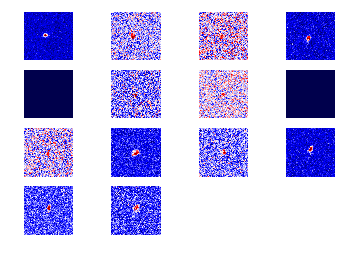

In [36]:
%matplotlib inline
num_cols = 4
num_rows = 4
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        if plt_idx <= len(cells):
            try:
                space, time = ft.decompose(stas[plt_idx-1] - np.mean(stas[plt_idx-1]))
            except:
                space = np.zeros((50,50))

            plt.subplot(num_rows, num_cols, plt_idx)
            plt.imshow(space - np.mean(space), cmap='seismic')
            plt.axis('off')

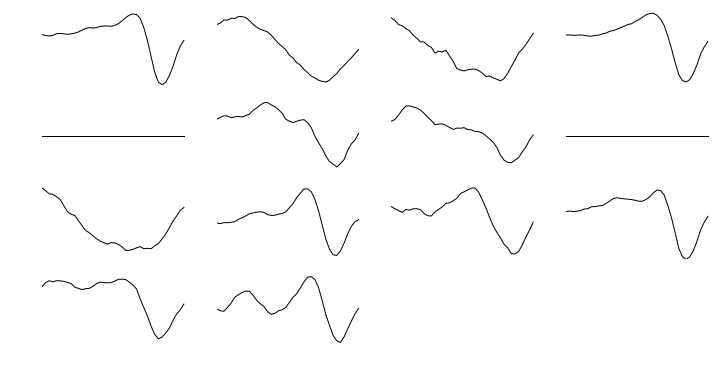

In [37]:
# %matplotlib inline
fig = plt.gcf()
fig.set_size_inches((12,6))
num_cols = 4
num_rows = 4
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        if plt_idx <= len(cells):
            try:
                space, time = ft.decompose(stas[plt_idx-1] - np.mean(stas[plt_idx-1]))
            except:
                time = np.zeros((40,))

            plt.subplot(num_rows, num_cols, plt_idx)
            plt.plot(time, 'k')
            plt.axis('off')

#### save STAs

In [38]:
from deepretina.visualizations import visualize_sta

Using gpu device 0: GeForce GT 750M (CNMeM is disabled)


In [39]:
for c in range(len(cells)):
    try:
        space, time = ft.decompose(stas[c] - np.mean(stas[c]))
    except:
        space = np.zeros((50,50))
    plt.imshow(space - np.mean(space), cmap='seismic')
    plt_filename = 'sta_cell_%d.png' %(c)
    plt.savefig(plt_filename)
    plt.close()

# Rasters during natural movies

(0, 60)

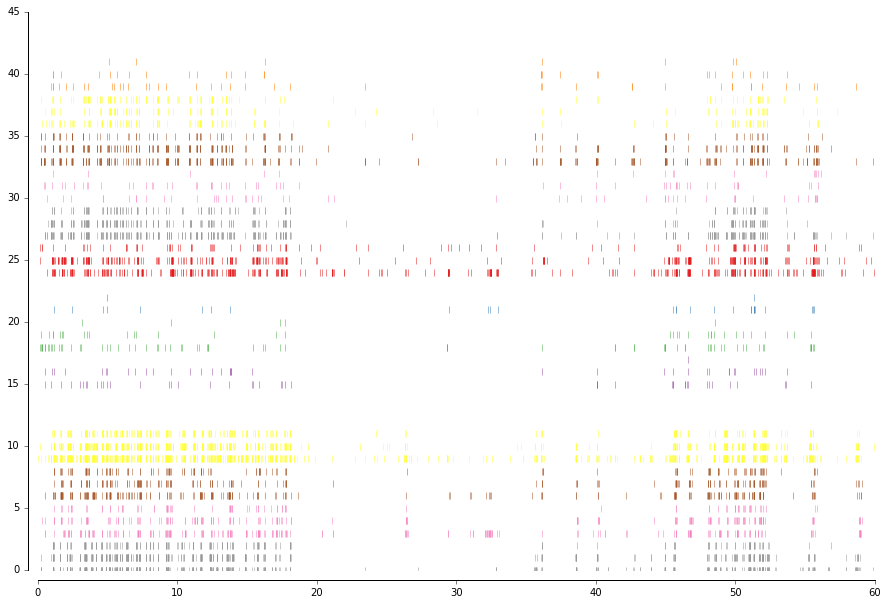

In [40]:
fig = plt.gcf()
fig.set_size_inches((15,10))

ax = plt.gca()
bmap = brewer2mpl.get_map('Set1', 'Qualitative', 9, reverse=True)
colors = bmap.mpl_colors

# structured stimuli
first_trial = 7
num_diff_trials = 8
total_trials = 24
num_repeats = 3
for c in range(len(cells)):
    repeats = []
    for t in range(first_trial, total_trials, num_diff_trials):
        repeats.append(expt_spikes[t][c])

    all_spikes, all_labels = spikes_to_array(repeats)
    all_labels += num_repeats * c
    
    # plot raster for this particular cell
    which_color = c % 9
    ax.plot(all_spikes, all_labels, '|', markersize=7, color=colors[which_color])

plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.xlim([0, 60])

# Save h5 files

In [41]:
import h5py
from pyret.spiketools import binspikes

In [42]:
def gaussian_filter(std, nbins=20, bin_length=10.0, return_x=False):
    '''
    INPUTS:
    std           in ms
    nbins         width of filter in bins
    bin_length    length of each bin, in ms. std is divided by this.
    '''
    std = std/bin_length
    x1 = np.linspace(-nbins/2, 0, nbins/2)
    x2 = np.linspace(0, nbins/2, nbins/2)
    x = np.hstack([x1, x2[1:]])
    gauss = (1./(std * np.sqrt(2*np.math.pi)))*np.exp(-(x**2)/(2*std**2))
    gauss /= np.sum(gauss) # make sum to 1
    if not return_x:
        return gauss
    else:
        return x, gauss

#### expts to each stim type

In [43]:
whitenoise_train_expts = [0, 8, 16]
whitenoise_test_expts = [1, 9, 17]
naturalscene_train_expts = [2, 10, 18]
naturalscene_test_expts = [3, 11, 19]
structured_train_expts = [4, 12, 20]
structured_test_expts = [5, 13, 21]
naturalmovie_train_expts = [6, 14, 22]
naturalmovie_test_expts = [7, 15, 23]

#### whitenoise

In [44]:
h = h5py.File('/Users/lmcintosh/experiments/data/16-01-08/whitenoise.h5', 'w')

##### spikes #####
ncells = len(cells)
for idx in range(ncells):
    h.create_dataset('spikes/cell%02d' %(idx+1), data=np.array(cells[idx]))

##### train #####
train_stimuli = []
train_times = []
train_response_binned = []
train_response_5ms = []
train_response_10ms = []
train_response_20ms = []
last_time = 0.0
for idx in whitenoise_train_expts:
    expt_name = 'expt%d' %(idx+1)
    stim = f[expt_name + '/stim']
    time = f[expt_name + '/timestamps']
    stimulus_upsample, time_upsample = stimtools.upsample_stim(stim, 3, time)
    binned_spikes = []
    response_5ms = []
    response_10ms = []
    response_20ms = []
    for c in range(len(cells)):
        bspk, tax = binspikes(expt_spikes[idx][c], binsize=0.01, time=time_upsample)
        binned_spikes.append(bspk)
        r5ms = st.estfr(tax, bspk, sigma=0.005) # 5 ms Gaussian
        r10ms = st.estfr(tax, bspk, sigma=0.01) # 10 ms Gaussian
        r20ms = st.estfr(tax, bspk, sigma=0.02) # 20 ms Gaussian
        response_5ms.append(r5ms)
        response_10ms.append(r10ms)
        response_20ms.append(r20ms)
        
    train_response_binned.append(np.vstack(binned_spikes))
    train_response_5ms.append(np.vstack(response_5ms))
    train_response_10ms.append(np.vstack(response_10ms))
    train_response_20ms.append(np.vstack(response_20ms))
    train_stimuli.append(stimulus_upsample[:-1])
    train_times.append(time_upsample[:-1] + last_time)
    last_time += time_upsample[-1]
# create datasets
h.create_dataset('train/stimulus', data=np.vstack(train_stimuli))
h.create_dataset('train/time', data=np.hstack(train_times))
h.create_dataset('train/response/binned', data=np.hstack(train_response_binned))
h.create_dataset('train/response/firing_rate_10ms', data=np.hstack(train_response_10ms))
h.create_dataset('train/response/firing_rate_20ms', data=np.hstack(train_response_20ms))
h.create_dataset('train/response/firing_rate_5ms', data=np.hstack(train_response_5ms))

<HDF5 dataset "firing_rate_5ms": shape (14, 179970), type "<f8">

In [45]:
##### test #####
test_stimuli = []
test_times = []
test_response_binned = []
test_response_5ms = []
test_response_10ms = []
test_response_20ms = []
test_repeats = []
for repeat, idx in enumerate(whitenoise_test_expts):
    expt_name = 'expt%d' %(idx+1)
    stim = f[expt_name + '/stim']
    time = f[expt_name + '/timestamps']
    stimulus_upsample, time_upsample = stimtools.upsample_stim(stim, 3, time)
    binned_spikes = []
    response_5ms = []
    response_10ms = []
    response_20ms = []
    for c in range(len(cells)):
        bspk, tax = binspikes(expt_spikes[idx][c], binsize=0.01, time=time_upsample)
        binned_spikes.append(bspk)
        r5ms = st.estfr(tax, bspk, sigma=0.005) # 5 ms Gaussian
        r10ms = st.estfr(tax, bspk, sigma=0.01) # 10 ms Gaussian
        r20ms = st.estfr(tax, bspk, sigma=0.02) # 20 ms Gaussian
        response_5ms.append(r5ms)
        response_10ms.append(r10ms)
        response_20ms.append(r20ms)
        
        if repeat == 0:
            test_repeats.append([r10ms])
        else:
            test_repeats[c].append(r10ms)
    test_response_binned.append(np.vstack(binned_spikes))
    test_response_5ms.append(np.vstack(response_5ms))
    test_response_10ms.append(np.vstack(response_10ms))
    test_response_20ms.append(np.vstack(response_20ms))
# create datasets
h.create_dataset('test/stimulus', data=stimulus_upsample[:-1])
h.create_dataset('test/time', data=time_upsample[:-1])
h.create_dataset('test/response/binned', data=np.mean(test_response_binned, axis=0))
h.create_dataset('test/response/firing_rate_10ms', data=np.mean(test_response_10ms, axis=0))
h.create_dataset('test/response/firing_rate_20ms', data=np.mean(test_response_20ms, axis=0))
h.create_dataset('test/response/firing_rate_5ms', data=np.mean(test_response_5ms, axis=0))
for c in range(len(cells)):
    dataset_name = 'test/repeats/cell%02d' %(c+1)
    h.create_dataset(dataset_name, data=np.vstack(test_repeats[c]))

h.close()

#### naturalscene

In [46]:
h = h5py.File('/Users/lmcintosh/experiments/data/16-01-08/naturalscene.h5', 'w')

##### spikes #####
ncells = len(cells)
for idx in range(ncells):
    h.create_dataset('spikes/cell%02d' %(idx+1), data=np.array(cells[idx]))

##### train #####
train_stimuli = []
train_times = []
train_response_binned = []
train_response_5ms = []
train_response_10ms = []
train_response_20ms = []
last_time = 0.0
for idx in naturalscene_train_expts:
    expt_name = 'expt%d' %(idx+1)
    stim = f[expt_name + '/stim']
    time = f[expt_name + '/timestamps']
    stimulus_upsample, time_upsample = stimtools.upsample_stim(stim, 3, time)
    binned_spikes = []
    response_5ms = []
    response_10ms = []
    response_20ms = []
    for c in range(len(cells)):
        bspk, tax = binspikes(expt_spikes[idx][c], binsize=0.01, time=time_upsample)
        binned_spikes.append(bspk)
        r5ms = st.estfr(tax, bspk, sigma=0.005) # 5 ms Gaussian
        r10ms = st.estfr(tax, bspk, sigma=0.01) # 10 ms Gaussian
        r20ms = st.estfr(tax, bspk, sigma=0.02) # 20 ms Gaussian
        response_5ms.append(r5ms)
        response_10ms.append(r10ms)
        response_20ms.append(r20ms)
    train_response_binned.append(np.vstack(binned_spikes))
    train_response_5ms.append(np.vstack(response_5ms))
    train_response_10ms.append(np.vstack(response_10ms))
    train_response_20ms.append(np.vstack(response_20ms))
    train_stimuli.append(stimulus_upsample[:-1])
    train_times.append(time_upsample[:-1] + last_time)
    last_time += time_upsample[-1]
# create datasets
h.create_dataset('train/stimulus', data=np.vstack(train_stimuli))
h.create_dataset('train/time', data=np.hstack(train_times))
h.create_dataset('train/response/binned', data=np.hstack(train_response_binned))
h.create_dataset('train/response/firing_rate_10ms', data=np.hstack(train_response_10ms))
h.create_dataset('train/response/firing_rate_20ms', data=np.hstack(train_response_20ms))
h.create_dataset('train/response/firing_rate_5ms', data=np.hstack(train_response_5ms))

##### test #####
test_stimuli = []
test_times = []
test_response_binned = []
test_response_5ms = []
test_response_10ms = []
test_response_20ms = []
test_repeats = []
for repeat, idx in enumerate(naturalscene_test_expts):
    expt_name = 'expt%d' %(idx+1)
    stim = f[expt_name + '/stim']
    time = f[expt_name + '/timestamps']
    stimulus_upsample, time_upsample = stimtools.upsample_stim(stim, 3, time)
    binned_spikes = []
    response_5ms = []
    response_10ms = []
    response_20ms = []
    for c in range(len(cells)):
        bspk, tax = binspikes(expt_spikes[idx][c], binsize=0.01, time=time_upsample)
        binned_spikes.append(bspk)
        r5ms = st.estfr(tax, bspk, sigma=0.005) # 5 ms Gaussian
        r10ms = st.estfr(tax, bspk, sigma=0.01) # 10 ms Gaussian
        r20ms = st.estfr(tax, bspk, sigma=0.02) # 20 ms Gaussian
        response_5ms.append(r5ms)
        response_10ms.append(r10ms)
        response_20ms.append(r20ms)
        if repeat == 0:
            test_repeats.append([r10ms])
        else:
            test_repeats[c].append(r10ms)
    test_response_binned.append(np.vstack(binned_spikes))
    test_response_5ms.append(np.vstack(response_5ms))
    test_response_10ms.append(np.vstack(response_10ms))
    test_response_20ms.append(np.vstack(response_20ms))
# create datasets
h.create_dataset('test/stimulus', data=stimulus_upsample[:-1])
h.create_dataset('test/time', data=time_upsample[:-1])
h.create_dataset('test/response/binned', data=np.mean(test_response_binned, axis=0))
h.create_dataset('test/response/firing_rate_10ms', data=np.mean(test_response_10ms, axis=0))
h.create_dataset('test/response/firing_rate_20ms', data=np.mean(test_response_20ms, axis=0))
h.create_dataset('test/response/firing_rate_5ms', data=np.mean(test_response_5ms, axis=0))
for c in range(len(cells)):
    dataset_name = 'test/repeats/cell%02d' %(c+1)
    h.create_dataset(dataset_name, data=np.vstack(test_repeats[c]))

h.close()

#### structured

In [47]:
h = h5py.File('/Users/lmcintosh/experiments/data/16-01-08/structured.h5', 'w')

##### spikes #####
ncells = len(cells)
for idx in range(ncells):
    h.create_dataset('spikes/cell%02d' %(idx+1), data=np.array(cells[idx]))

##### train #####
train_stimuli = []
train_times = []
train_response_binned = []
train_response_5ms = []
train_response_10ms = []
train_response_20ms = []
last_time = 0.0
for idx in structured_train_expts:
    expt_name = 'expt%d' %(idx+1)
    stim = f[expt_name + '/stim']
    time = f[expt_name + '/timestamps']
    stimulus_upsample, time_upsample = stimtools.upsample_stim(stim, 3, time)
    binned_spikes = []
    response_5ms = []
    response_10ms = []
    response_20ms = []
    for c in range(len(cells)):
        bspk, tax = binspikes(expt_spikes[idx][c], binsize=0.01, time=time_upsample)
        binned_spikes.append(bspk)
        r5ms = st.estfr(tax, bspk, sigma=0.005) # 5 ms Gaussian
        r10ms = st.estfr(tax, bspk, sigma=0.01) # 10 ms Gaussian
        r20ms = st.estfr(tax, bspk, sigma=0.02) # 20 ms Gaussian
        response_5ms.append(r5ms)
        response_10ms.append(r10ms)
        response_20ms.append(r20ms)
    train_response_binned.append(np.vstack(binned_spikes))
    train_response_5ms.append(np.vstack(response_5ms))
    train_response_10ms.append(np.vstack(response_10ms))
    train_response_20ms.append(np.vstack(response_20ms))
    train_stimuli.append(stimulus_upsample[:-1])
    train_times.append(time_upsample[:-1] + last_time)
    last_time += time_upsample[-1]
# create datasets
h.create_dataset('train/stimulus', data=np.vstack(train_stimuli))
h.create_dataset('train/time', data=np.hstack(train_times))
h.create_dataset('train/response/binned', data=np.hstack(train_response_binned))
h.create_dataset('train/response/firing_rate_10ms', data=np.hstack(train_response_10ms))
h.create_dataset('train/response/firing_rate_20ms', data=np.hstack(train_response_20ms))
h.create_dataset('train/response/firing_rate_5ms', data=np.hstack(train_response_5ms))

##### test #####
test_stimuli = []
test_times = []
test_response_binned = []
test_response_5ms = []
test_response_10ms = []
test_response_20ms = []
test_repeats = []
for repeat, idx in enumerate(structured_test_expts):
    expt_name = 'expt%d' %(idx+1)
    stim = f[expt_name + '/stim']
    time = f[expt_name + '/timestamps']
    stimulus_upsample, time_upsample = stimtools.upsample_stim(stim, 3, time)
    binned_spikes = []
    response_5ms = []
    response_10ms = []
    response_20ms = []
    for c in range(len(cells)):
        bspk, tax = binspikes(expt_spikes[idx][c], binsize=0.01, time=time_upsample)
        binned_spikes.append(bspk)
        r5ms = st.estfr(tax, bspk, sigma=0.005) # 5 ms Gaussian
        r10ms = st.estfr(tax, bspk, sigma=0.01) # 10 ms Gaussian
        r20ms = st.estfr(tax, bspk, sigma=0.02) # 20 ms Gaussian
        response_5ms.append(r5ms)
        response_10ms.append(r10ms)
        response_20ms.append(r20ms)
        if repeat == 0:
            test_repeats.append([r10ms])
        else:
            test_repeats[c].append(r10ms)
    test_response_binned.append(np.vstack(binned_spikes))
    test_response_5ms.append(np.vstack(response_5ms))
    test_response_10ms.append(np.vstack(response_10ms))
    test_response_20ms.append(np.vstack(response_20ms))
# create datasets
h.create_dataset('test/stimulus', data=stimulus_upsample[:-1])
h.create_dataset('test/time', data=time_upsample[:-1])
h.create_dataset('test/response/binned', data=np.mean(test_response_binned, axis=0))
h.create_dataset('test/response/firing_rate_10ms', data=np.mean(test_response_10ms, axis=0))
h.create_dataset('test/response/firing_rate_20ms', data=np.mean(test_response_20ms, axis=0))
h.create_dataset('test/response/firing_rate_5ms', data=np.mean(test_response_5ms, axis=0))
for c in range(len(cells)):
    dataset_name = 'test/repeats/cell%02d' %(c+1)
    h.create_dataset(dataset_name, data=np.vstack(test_repeats[c]))

h.close()

#### naturalmovie

In [48]:
h = h5py.File('/Users/lmcintosh/experiments/data/16-01-08/naturalmovie.h5', 'w')

##### spikes #####
ncells = len(cells)
for idx in range(ncells):
    h.create_dataset('spikes/cell%02d' %(idx+1), data=np.array(cells[idx]))

##### train #####
train_stimuli = []
train_times = []
train_response_binned = []
train_response_5ms = []
train_response_10ms = []
train_response_20ms = []
last_time = 0.0
for idx in naturalmovie_train_expts:
    expt_name = 'expt%d' %(idx+1)
    stim = f[expt_name + '/stim']
    time = f[expt_name + '/timestamps']
    stimulus_upsample, time_upsample = stimtools.upsample_stim(stim, 3, time)
    binned_spikes = []
    response_5ms = []
    response_10ms = []
    response_20ms = []
    for c in range(len(cells)):
        bspk, tax = binspikes(expt_spikes[idx][c], binsize=0.01, time=time_upsample)
        binned_spikes.append(bspk)
        r5ms = st.estfr(tax, bspk, sigma=0.005) # 5 ms Gaussian
        r10ms = st.estfr(tax, bspk, sigma=0.01) # 10 ms Gaussian
        r20ms = st.estfr(tax, bspk, sigma=0.02) # 20 ms Gaussian
        response_5ms.append(r5ms)
        response_10ms.append(r10ms)
        response_20ms.append(r20ms)
    train_response_binned.append(np.vstack(binned_spikes))
    train_response_5ms.append(np.vstack(response_5ms))
    train_response_10ms.append(np.vstack(response_10ms))
    train_response_20ms.append(np.vstack(response_20ms))
    train_stimuli.append(stimulus_upsample[:-1])
    train_times.append(time_upsample[:-1] + last_time)
    last_time += time_upsample[-1]
# create datasets
h.create_dataset('train/stimulus', data=np.vstack(train_stimuli))
h.create_dataset('train/time', data=np.hstack(train_times))
h.create_dataset('train/response/binned', data=np.hstack(train_response_binned))
h.create_dataset('train/response/firing_rate_10ms', data=np.hstack(train_response_10ms))
h.create_dataset('train/response/firing_rate_20ms', data=np.hstack(train_response_20ms))
h.create_dataset('train/response/firing_rate_5ms', data=np.hstack(train_response_5ms))

##### test #####
test_stimuli = []
test_times = []
test_response_binned = []
test_response_5ms = []
test_response_10ms = []
test_response_20ms = []
test_repeats = []
for repeat, idx in enumerate(naturalmovie_test_expts):
    expt_name = 'expt%d' %(idx+1)
    stim = f[expt_name + '/stim']
    time = f[expt_name + '/timestamps']
    stimulus_upsample, time_upsample = stimtools.upsample_stim(stim, 3, time)
    binned_spikes = []
    response_5ms = []
    response_10ms = []
    response_20ms = []
    for c in range(len(cells)):
        bspk, tax = binspikes(expt_spikes[idx][c], binsize=0.01, time=time_upsample)
        binned_spikes.append(bspk)
        r5ms = st.estfr(tax, bspk, sigma=0.005) # 5 ms Gaussian
        r10ms = st.estfr(tax, bspk, sigma=0.01) # 10 ms Gaussian
        r20ms = st.estfr(tax, bspk, sigma=0.02) # 20 ms Gaussian
        response_5ms.append(r5ms)
        response_10ms.append(r10ms)
        response_20ms.append(r20ms)
        if repeat == 0:
            test_repeats.append([r10ms])
        else:
            test_repeats[c].append(r10ms)
    test_response_binned.append(np.vstack(binned_spikes))
    test_response_5ms.append(np.vstack(response_5ms))
    test_response_10ms.append(np.vstack(response_10ms))
    test_response_20ms.append(np.vstack(response_20ms))
# create datasets
h.create_dataset('test/stimulus', data=stimulus_upsample[:-1])
h.create_dataset('test/time', data=time_upsample[:-1])
h.create_dataset('test/response/binned', data=np.mean(test_response_binned, axis=0))
h.create_dataset('test/response/firing_rate_10ms', data=np.mean(test_response_10ms, axis=0))
h.create_dataset('test/response/firing_rate_20ms', data=np.mean(test_response_20ms, axis=0))
h.create_dataset('test/response/firing_rate_5ms', data=np.mean(test_response_5ms, axis=0))
for c in range(len(cells)):
    dataset_name = 'test/repeats/cell%02d' %(c+1)
    h.create_dataset(dataset_name, data=np.vstack(test_repeats[c]))

h.close()

# After training models on this experiment, it seems like train and test data are on different scales

In [49]:
f = h5py.File('/Users/lmcintosh/experiments/data/16-01-08/whitenoise.h5', 'r')

In [50]:
list(f)

[u'spikes', u'test', u'train']

In [51]:
list(f['test'])

[u'repeats', u'response', u'stimulus', u'time']

In [52]:
list(f['train'])

[u'response', u'stimulus', u'time']

In [53]:
list(f['test/response'])

[u'binned', u'firing_rate_10ms', u'firing_rate_20ms', u'firing_rate_5ms']

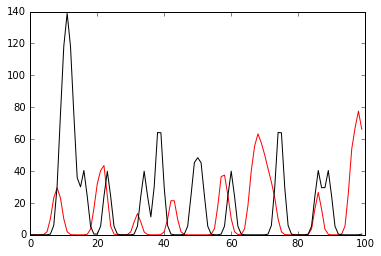

In [54]:
test_segment = np.array(f['test/response/firing_rate_10ms'])
train_segment = np.array(f['train/response/firing_rate_10ms'])

plt.plot(test_segment[0,:100], 'r')
plt.plot(train_segment[0,:100], 'k')

In [55]:
f.close()

#### and now it's fixed!